#  Estimation of Orbital Parameters of Extra-solar Planets from Radial Velocities using Maximum Likelihood Estimation (MLE)

## Maximum Likelihood Estimation

MLE is used to determine the parameters of a probability distribution by maximizing a likelihood function, so that under the assumed statistical model the observed data is most probable. It provides a framework for predictive modeling where finding model parameters can be framed as an optimization problem. Maximum likelihood estimation is a completely analytic maximization procedure. It is an unbiased minimum variance estimators for a large sample size. This method does not try to minimize the difference to the data, but tries to maximize the likelihood that the data could have been generated by the model.

## Log Likelihood Function


Let $\mathrm{Y_1, Y_2, Y_3,...Y_n}$ be the independent and identically distributed (i.i.d.) random variables with a joint probability density denoted by

\begin{equation} f_\Theta(y_1, y_2, y_3...y_n) = f(y_1, y_2, y_3...y_n\;|\;\Theta)\mathrm{\tag{1}}\end{equation}

where $y_1, y_2, y_3...y_n$ are the observed values. The likelihood of the parameter $\Theta$ is the function

\begin{equation} L(\Theta) = f(y_1, y_2, y_3...y_n\;|\;\Theta)\mathrm{\tag{2}}\end{equation}

It is defined as the probability of observing the given data as a function of $\Theta$. The ML estimate of $\Theta$ is that value of $\Theta$ that maximises the likelihood function and makes the observed data the most probable. As $\mathrm{Y_1, Y_2, Y_3,...Y_n}$ are i.i.d., then the likelihood simplifies to

\begin{equation} L(\Theta) = \prod_{i=1}^{n}f(y_i\;|\;\Theta)\mathrm{\tag{3}}\end{equation}

For different values of parameters, the likelihood of the data is different. For the correct parameter values, the data is more probable than than the data with incorrect parameters. For this reason, the likelihood is written as a function of the parameter set, $\Theta$.

## Maximization Process


The ultimate aim is to chose values of our parameters ($\Theta$) that maximizesthe likelihood function. Let $\widehat{\Theta}$ represents the best choice of values for our parameters. Therefore, in other words:

\begin{equation} \widehat{\Theta} = \max_{\Theta}L(\Theta)\mathrm{\tag{4}}\end{equation}

The maximum argument of a function is the value of the domain at which the value of the function is maximized. Since log ia a monotonic function, maximizing a function or the log of that function is same.   Thus, for MLE the Log Likelihood function (LL) is written as:

\begin{equation} LL(\Theta) = log\; L(\Theta) = log\; \prod_{i=1}^{n}f(y_i\;|\;\Theta) = \sum_{i=1}^{n}log\; f(y_i\;|\;\Theta) \mathrm{\tag{5}}\end{equation}


## The Data

We shall use the ML estimate to know more about characteristics of the planetary system, 51 Pegasi (HD 217014). The radial velocity (RV) data was obtained from NASA Exoplanet Archive which is maintained by the [NASA Exoplanet Science](https://exoplanetarchive.ipac.caltech.edu/). Let the data be denoted by $y_i$ of which we are interested to make inferences.


## Fitting the Exoplanet's Radial Velocity

The RV data of 51 Pegasi can be downloaded from the archive. We are interested in the RV values with thier errors as a function of the Julian Date. For representation purpose, we shall phase-fold the time axis.

In [1]:
#!/usr/bin/env python3
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import math
import emcee
import corner
import pickle
import tkinter as tk
from tkinter import simpledialog
from tkinter.simpledialog import askinteger
import easygui
from IPython.display import display, Math
from numpy.linalg import inv
from sympy import symbols, diff, pi, cos, sin
import time
from time import perf_counter
from tqdm import tqdm
from traits.api import HasTraits, Instance, Array, \
    on_trait_change
from traitsui.api import View, Item, HGroup, Group

from tvtk.api import tvtk
from tvtk.pyface.scene import Scene

from mayavi import mlab
from mayavi.core.api import PipelineBase, Source
from mayavi.core.ui.api import SceneEditor, MayaviScene, \
                                MlabSceneModel

plt.rcParams['figure.figsize'] = [12,7]

                0          1         2
0    2.450003e+06 -28.980785  1.345139
1    2.450003e+06 -33.494823  1.467521
2    2.450003e+06 -38.008003  1.840782
3    2.450004e+06  -9.878883  1.157139
4    2.450004e+06  -2.043795  0.981048
..            ...        ...       ...
197  2.455528e+06 -34.615391  1.353431
198  2.455547e+06   5.948516  2.245812
199  2.455844e+06  25.590000  3.590000
200  2.455845e+06 -28.450001  2.820000
201  2.455847e+06  -9.530000  2.430000

[202 rows x 3 columns]


<ipython-input-2-80b835a41acb>:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(HJD, Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


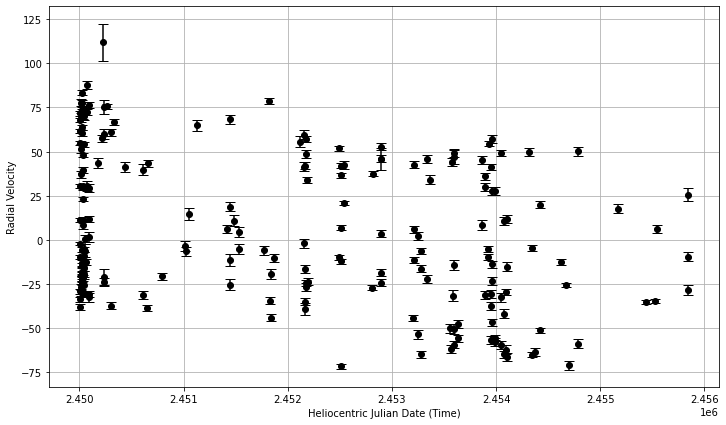

<Figure size 864x504 with 0 Axes>

In [2]:
Data = pd.read_table('UID_0113357_RVC_005.dat',sep = '\s+',skiprows=22, header = None, index_col = None)
print(Data)
RV_Data = np.array(Data)
HJD = RV_Data[:,[0]]
Rad_Vel = RV_Data[:,[1]]
RV_Error = RV_Data[:,[2]]
plt.errorbar(HJD, Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.xlabel('Heliocentric Julian Date (Time)')
plt.ylabel('Radial Velocity')
plt.grid()
plt.show(block=False)
len_HJD = len(HJD)
Phase_Folded = np.empty((len_HJD, len_HJD))
fig = plt.figure()

<ipython-input-3-457c1cee91bc>:31: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*Phase_Folded[:,[j]], Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


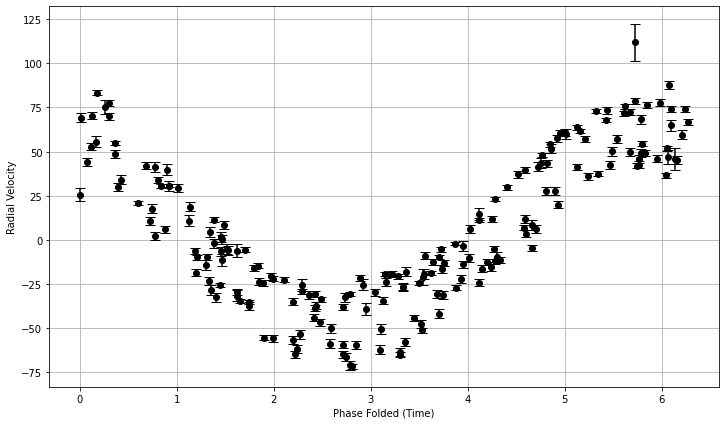

In [3]:
for i in range(0,len_HJD):
    t = HJD
    T0 = HJD[i]
    P = 4.230785
    PF = ((t-T0)/P)-np.floor((t-T0)/P)
    Phase_Folded[:,[i]] = PF


root =tk.Tk()
canvas1 = tk.Canvas(root, width = 400, height = 200,  relief = 'raised')
canvas1.pack()

label1 = tk.Label(root, text='Select the Reference Time (Fiducial)')
label1.config(font=('helvetica', 14))
canvas1.create_window(200, 25, window=label1)

label2 = tk.Label(root, text='Input the n\u1D57\u02B0 HJD to be taken as the reference \n\n(n\u2208Z\u207a; 1 \u2264 n \u2264 202):')
label2.config(font=('helvetica', 10))
canvas1.create_window(200, 95, window=label2)
mystring =tk.IntVar(root)
def close_window():
    root.destroy()
e1 = tk.Entry(root,textvariable = mystring,width=25,fg="black",bd=3,selectbackground='gray').place(x=100, y=120)
button1 = tk.Button(root, 
                text='Submit', 
                fg='White', 
                bg= '#000000',height = 1, width = 10,command=close_window).place(x=150, y=170)
root.mainloop()
j = mystring.get() 
j = j-1
plt.errorbar(2*np.pi*Phase_Folded[:,[j]], Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.xlabel('Phase Folded (Time)')
plt.ylabel('Radial Velocity')
plt.grid()
plt.show(block=False)
x_data = Phase_Folded[:,[j]]
x_model = np.linspace(0, 1, 5000)
data = (x_data,Rad_Vel,RV_Error)

The underlying fit appears to be a sinusoid. So, we shall use the following function to model the data:

\begin{equation} y = y_0 + A_0\; cos(2\, \pi\, x + \Phi_0) \mathrm{\tag{6}}\end{equation}

where y_0, A_0,and \Phi_0 are the parameters. Let there be $N$ points to fit. For a data point, the probability distribution function (PDF) is

\begin{equation} P\,(y_i\, |\, x_i, \Delta\, y_i, y_0, A_0, \Phi_0) = \frac{1}{\Delta\, y_i \sqrt{2 \pi}}~\exp \left( - \frac{\{y_i - [y_0 + A_0\; cos(2\, \pi\, x + \Phi_0)]\}^2}
{2 (\Delta\, y_i)^2} \right) \mathrm{\tag{7}}\end{equation}

For all the data points,

\begin{equation} P\,(y\, |\, x, \Delta\, y, y_0, A_0, \Phi_0) = \prod_{i=1}^{n}\frac{1}{\Delta\, y_i \sqrt{2 \pi}}~\exp \left( - \frac{\{y_i - [y_0 + A_0\; cos(2\, \pi\, x + \Phi_0)]\}^2}
{2 (\Delta\, y_i)^2} \right) \mathrm{\tag{8}}\end{equation}

\begin{equation} P\,(y\, |\, x, \Delta\, y, y_0, A_0, \Phi_0) = \frac{1}{{(2 \pi)}^{\frac{N}{2}}}\prod_{i=1}^{n}\frac{1}{\Delta\, y_i}~\exp \left( - \frac{\{y_i - [y_0 + A_0\; cos(2\, \pi\, x + \Phi_0)]\}^2}
{2 (\Delta\, y_i)^2} \right) \mathrm{\tag{9}}\end{equation}

\begin{equation} ln\, P = ln\,\left(\frac{1}{{(2 \pi)}^{\frac{N}{2}}}\right)\:-\:ln\:\prod_{i=1}^{n}\frac{1}{\Delta\, y_i}~\exp \left( - \frac{\{y_i - [y_0 + A_0\; cos(2\, \pi\, x + \Phi_0)]\}^2}
{2 (\Delta\, y_i)^2} \right) \mathrm{\tag{10}}\end{equation}

\begin{equation} = ln\:(2\, \pi\, \Delta y_i^2)+ \left(\frac{\{y_i - [y_0 + A_0\; cos(2\, \pi\, x + \Phi_0)]\}^2}
{2 (\Delta\, y_i)^2} \right) \mathrm{\tag{11}}\end{equation}





## Fisher Information Matrix $(I)$

The Fisher information is a way of measuring the amount of information that an observable random variable $Y$ carries about an unknown parameter $\Theta$ of a distribution that models $Y$. It is used to calculate the covariance matrices associated with maximum-likelihood estimates. It is given by

\begin{equation} I(\Theta) = \textbf{E}\left[-\frac{\partial^2}{\partial \,\Theta^2}\,ln\; f(Y\;|\;\Theta)\right]\mathrm{\tag{12}}\end{equation}


The Fisher information for the parameter $A_0$ is

\begin{equation} I(A_0) = -\textbf{E}\left[\frac{\partial^2}{\partial \,A_0^2}\,ln\, P\right] = \sum_{i=1}^{N}\frac{cos^2\, (2\, \pi\, x + \Phi_0)}{\Delta y_i^2}\mathrm{\tag{13}}\end{equation}


For the parameter $y_0$

\begin{equation} I(y_0) = -\textbf{E}\left[\frac{\partial^2}{\partial \,y_0^2}\,ln\, P\right] = -\textbf{E}\left[-\sum_{i=1}^{N}\frac{1}{\Delta y_i^2}\right] = \sum_{i=1}^{N}\frac{1}{\Delta y_i^2}\mathrm{\tag{14}}\end{equation}

For the parameter $\Phi_0$

\begin{equation} I(\Phi_0) = -\textbf{E}\left[\frac{\partial^2}{\partial \,\Phi_0^2}\,ln\, P\right]\mathrm{\tag{15}}\end{equation}

\begin{equation} \frac{\partial^2}{\partial \,\Phi_0^2}\,ln\, P = \sum_{i=1}^{N}\, \frac{A_0}{\Delta y_i^2} \{A_0\; cos(4\, \pi\, x + 2\, \Phi_0) + (y_0 - y_i)\; cos(2\, \pi\, x + \Phi_0)\}\mathrm{\tag{16}}\end{equation}

Therefore,

\begin{equation} I(\Phi_0) = -\sum_{i=1}^{N}\, \frac{A_0}{\Delta y_i^2} \{A_0\; cos(4\, \pi\, x + 2\, \Phi_0) + (y_0 - y_i)\; cos(2\, \pi\, x + \Phi_0)\}\mathrm{\tag{17}}\end{equation}

We shall use this information to model our data.

In [5]:
#
# Model (y0 + A0*cos(2πx+Φ0))
#
def rvmodel_ml(Parameters,x=x_model):
    y0, A0, Phi0 = Parameters
    return y0 + (A0*np.cos((2*np.pi*x)+Phi0))

In [6]:
#
# Likelihood Function
#
def lnlike(Parameters,x,y,yerror):
    return -0.5*(np.sum((np.log(2*np.pi*(yerror**2)))+(((y-rvmodel_ml(Parameters,x))/yerror)**2)))

From the above plot, a rough estimate of the priors can be made.

In [7]:
#
# Initial Parameters, Lower and Upper Bounds
#
Param0 = np.array([-2.0, 100.0, 3.0])
bounds = ((-50.0,50.0),(0.0,125.0),(0.0,2*np.pi))

In [8]:
#
# Maximum Likelihood Fit
#
ln = lambda*args: -lnlike(*args)
output = minimize(ln, Param0, args=data, bounds=bounds, tol= 1e-9)
offset_ml, amplitude_ml, phase_ml = output["x"]
ml_estimates = np.array([offset_ml, amplitude_ml, phase_ml])
ndim = len(ml_estimates)
best_fit_model_ml = rvmodel_ml(ml_estimates,x_model)

<ipython-input-9-1a47713a20aa>:1: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')


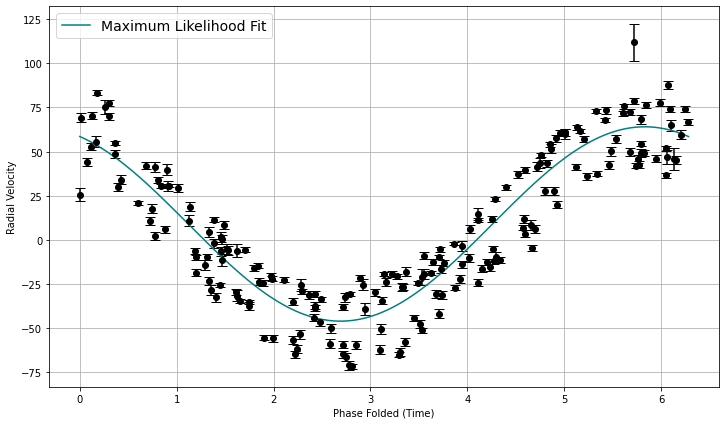

In [9]:
plt.errorbar(2*np.pi*x_data,Rad_Vel, RV_Error, color='black', fmt='o', capsize=5, capthick=1, ecolor='black')
plt.plot(2*np.pi*x_model,best_fit_model_ml,color='#008080', label="Maximum Likelihood Fit")
plt.xlabel('Phase Folded (Time)')
plt.ylabel('Radial Velocity')
plt.legend(fontsize=14)
plt.grid()
plt.show()

Let us obtain the parameter values.

In [11]:
a = 1/(RV_Error**2)
b = np.divide((np.cos((2*np.pi*x_data)+phase_ml))**2,RV_Error**2)
c = np.divide(((amplitude_ml*(Rad_Vel-offset_ml)*np.cos((2*np.pi*x_data)+phase_ml))-((amplitude_ml**2)*np.cos((4*np.pi*x_data)+(2*phase_ml)))),RV_Error**2)
yi, y_0, a0, x, phi, d_yi = symbols('yi y a0 x phi d_yi', real=True)
func = (-1/2)*(((yi-(y_0 + (a0*(cos((2*pi*x)+phi)))))/(d_yi))**2)
pd = diff(func, phi)
pd2 = diff(pd, phi)

Unct_y0 = np.sqrt(1/(np.sum(a)))
Unct_A0 = np.sqrt(1/(np.sum(b)))
Unct_Phi0 = np.sqrt(1/(np.sum(c)))
Uncertainties = np.array([Unct_y0, Unct_A0, Unct_Phi0],dtype = ('float64'))

print('\033[1m' + 'Parameters using Maximum Likelihood Method (Minimizing the negative Log-Likelihood)' + '\033[0m')
label = ['y₀', 'A₀', '𝛟₀']
for s in range(ndim):
    txt = "\mathrm{{{2}}} = {0:.9f}_{{-{1:.3f}}}^{{{1:.3f}}}"
    txt = txt.format(ml_estimates[s], Uncertainties[s], label[s])
    display(Math(txt))

Parameters using Maximum Likelihood Method (Minimizing the negative Log-Likelihood)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We shall now create a 4-dimensional grid in order to determine the degeneracies of the parameter space.

In [12]:
#create array to cover parameter space

from itertools import product
xi, yi, zi = np.ogrid[-75:75:50j, -200:200:100j, -6.28:6.28:50j]

m = xi.flatten()
n = yi.flatten()
o = zi.flatten()
mno = np.asarray(list(product(m, n, o)))


#calculate likelihoods

t0 = perf_counter();
L = np.array([lnlike(mno[v],x_data,Rad_Vel,RV_Error) for v in tqdm(range(len(mno)))])
t1 = perf_counter();
Execution_Time = t1-t0


100%|██████████| 250000/250000 [00:14<00:00, 17660.95it/s]


250000it [00:49, 5076.67it/s]


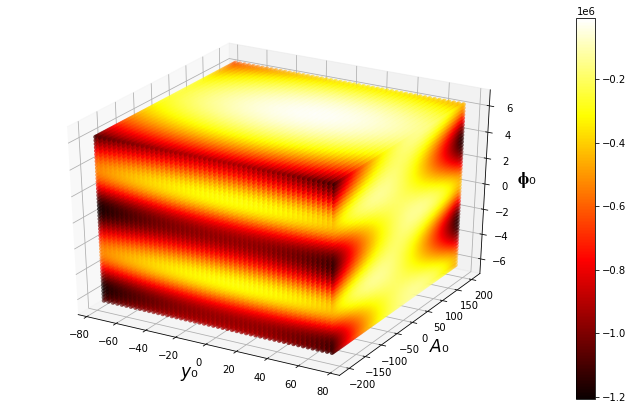

In [13]:
#t0 = time.time();
#results = []
#for i in tqdm(range(len(mno))):
#    results.append(lnlike(mno[i],x_data,Rad_Vel,RV_Error))
#LUP = np.hstack(results)
#t1 = time.time();
#Execution_Time = t1-t0


#select parameter with maximum likelihood
Likelihood_max = np.max(L)
MaxPos = mno[np.array([p for p,q in tqdm(enumerate(L)) if q==np.max(L)])]
#draw likelihood

  
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
img = ax.scatter(mno[:,0], mno[:,1], mno[:,2], c=L, lw=0, s=20, cmap=plt.hot())
ax.set_xlabel('$y₀$', fontsize=17)
ax.set_ylabel('$A₀$', fontsize=17)
ax.set_zlabel('$𝛟₀$', fontsize=17)
fig.colorbar(img)
plt.show()


We shall use MayaVi to visualise the variation of the log-likelihood in the grid. It is a scientific data visualizer written in Python, which uses VTK and provides a GUI via Tkinter. 

In [14]:

#Volume Slice in Mayavi


################################################################################

L_New = L.reshape(len(m),len(n),len(o))

################################################################################
# The object implementing the dialog
class VolumeSlicer(HasTraits):
    # The data to plot
    L_New = Array()

    # The 4 views displayed
    scene3d = Instance(MlabSceneModel, ())
    scene_x = Instance(MlabSceneModel, ())
    scene_y = Instance(MlabSceneModel, ())
    scene_z = Instance(MlabSceneModel, ())

    # The data source
    L_New_src3d = Instance(Source)

    # The image plane widgets of the 3D scene
    ipw_3d_x = Instance(PipelineBase)
    ipw_3d_y = Instance(PipelineBase)
    ipw_3d_z = Instance(PipelineBase)

    _axis_names = dict(x=0, y=1, z=2)


    #---------------------------------------------------------------------------
    def __init__(self, **traits):
        super(VolumeSlicer, self).__init__(**traits)
        # Force the creation of the image_plane_widgets:
        self.ipw_3d_x
        self.ipw_3d_y
        self.ipw_3d_z


    #---------------------------------------------------------------------------
    # Default values
    #---------------------------------------------------------------------------
    def _L_New_src3d_default(self):
        return mlab.pipeline.scalar_field(self.L_New,
                            figure=self.scene3d.mayavi_scene)

    def make_ipw_3d(self, axis_name):
        ipw = mlab.pipeline.image_plane_widget(self.L_New_src3d,
                        figure=self.scene3d.mayavi_scene,
                        plane_orientation='%s_axes' % axis_name)
        return ipw

    def _ipw_3d_x_default(self):
        return self.make_ipw_3d('x')

    def _ipw_3d_y_default(self):
        return self.make_ipw_3d('y')

    def _ipw_3d_z_default(self):
        return self.make_ipw_3d('z')


    #---------------------------------------------------------------------------
    # Scene activation callbaks
    #---------------------------------------------------------------------------
    @on_trait_change('scene3d.activated')
    def display_scene3d(self):
        outline = mlab.pipeline.outline(self.L_New_src3d,
                        figure=self.scene3d.mayavi_scene,
                        )
        self.scene3d.mlab.view(40, 50)
        # Interaction properties can only be changed after the scene
        # has been created, and thus the interactor exists
        for ipw in (self.ipw_3d_x, self.ipw_3d_y, self.ipw_3d_z):
            # Turn the interaction off
            ipw.ipw.interaction = 0
        self.scene3d.scene.background = (0, 0, 0)
        # Keep the view always pointing up
        self.scene3d.scene.interactor.interactor_style = \
                                 tvtk.InteractorStyleTerrain()


    def make_side_view(self, axis_name):
        scene = getattr(self, 'scene_%s' % axis_name)

        # To avoid copying the data, we take a reference to the
        # raw VTK dataset, and pass it on to mlab. Mlab will create
        # a Mayavi source from the VTK without copying it.
        # We have to specify the figure so that the data gets
        # added on the figure we are interested in.
        outline = mlab.pipeline.outline(
                            self.L_New_src3d.mlab_source.dataset,
                            figure=scene.mayavi_scene,
                            )
        ipw = mlab.pipeline.image_plane_widget(
                            outline,
                            plane_orientation='%s_axes' % axis_name)
        setattr(self, 'ipw_%s' % axis_name, ipw)

        # Synchronize positions between the corresponding image plane
        # widgets on different views.
        ipw.ipw.sync_trait('slice_position',
                            getattr(self, 'ipw_3d_%s'% axis_name).ipw)

        # Make left-clicking create a crosshair
        ipw.ipw.left_button_action = 0
        # Add a callback on the image plane widget interaction to
        # move the others
        def move_view(obj, evt):
            position = obj.GetCurrentCursorPosition()
            for other_axis, axis_number in self._axis_names.items():
                if other_axis == axis_name:
                    continue
                ipw3d = getattr(self, 'ipw_3d_%s' % other_axis)
                ipw3d.ipw.slice_position = position[axis_number]

        ipw.ipw.add_observer('InteractionEvent', move_view)
        ipw.ipw.add_observer('StartInteractionEvent', move_view)

        # Center the image plane widget
        ipw.ipw.slice_position = 0.5*self.L_New.shape[
                    self._axis_names[axis_name]]

        # Position the view for the scene
        views = dict(x=( 0, 90),
                     y=(90, 90),
                     z=( 0,  0),
                     )
        scene.mlab.view(*views[axis_name])
        # 2D interaction: only pan and zoom
        scene.scene.interactor.interactor_style = \
                                 tvtk.InteractorStyleImage()
        scene.scene.background = (0, 0, 0)


    @on_trait_change('scene_x.activated')
    def display_scene_x(self):
        return self.make_side_view('x')

    @on_trait_change('scene_y.activated')
    def display_scene_y(self):
        return self.make_side_view('y')

    @on_trait_change('scene_z.activated')
    def display_scene_z(self):
        return self.make_side_view('z')


    #---------------------------------------------------------------------------
    # The layout of the dialog created
    #---------------------------------------------------------------------------
    view = View(HGroup(
                  Group(
                       Item('scene_y',
                            editor=SceneEditor(scene_class=Scene),
                            height=250, width=300),
                       Item('scene_z',
                            editor=SceneEditor(scene_class=Scene),
                            height=250, width=300),
                       show_labels=False,
                  ),
                  Group(
                       Item('scene_x',
                            editor=SceneEditor(scene_class=Scene),
                            height=250, width=300),
                       Item('scene3d',
                            editor=SceneEditor(scene_class=MayaviScene),
                            height=250, width=300),
                       show_labels=False,
                  ),
                ),
                resizable=True,
                title='Volume Slicer',
                )


vs_plot = VolumeSlicer(L_New=L_New)
vs_plot.configure_traits()

True

The output is as follows:

<img src="snapshot.png" width="700" height="300">

**Developed and designed by [Shubhonkar Paramanick](https://github.com/Shubhonkar-Paramanick)**